In [1]:
import pandas as pd
import os
import shutil
import yaml
from pathlib import Path
import ast
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
from PIL import Image
from typing import List, Tuple, Dict
from tqdm.notebook import tqdm
import random
import hashlib
import json

In [2]:
vini = pd.read_csv('vinidir_final.csv')
vini = vini[vini.category!='No Finding'].reset_index(drop=True)
vini['image_paths'] = vini['image_paths'].str.replace(r'^../', '', regex=True)
# emory = emory.rename(columns={'asses': 'breast_birads', 'ViewPosition':'view','ImageLateralityFinal':'laterality'})

In [3]:
def display_images(data, idx):
    
    # Set the plot size
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(30, 10))
    axes = axes.ravel()

    for i, row in enumerate(data.iloc[idx].itertuples()):
        # Build image path
        img_file_path = row.image_paths

        # Open and show image
        if os.path.exists(img_file_path):
            img = Image.open(img_file_path)
            x1, y1, x2, y2 = row.resized_xmin, row.resized_ymin, row.resized_xmax, row.resized_ymax
            try:
                axes[i].imshow(img, cmap='gray')
                # Draw bounding box
                rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
                axes[i].add_patch(rect)
            except Exception as e:
                print(f"Cannot Display {img_file_path}, because of error:{e}")
                break
        else:
            axes[i].text(0.5, 0.5, 'Image not found', horizontalalignment='center', verticalalignment='center')
        
        # Set title with image attributes
        title_text = f"{i} Findings: {row.finding_categories}"
        axes[i].set_title(title_text, fontsize=8)
        # axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

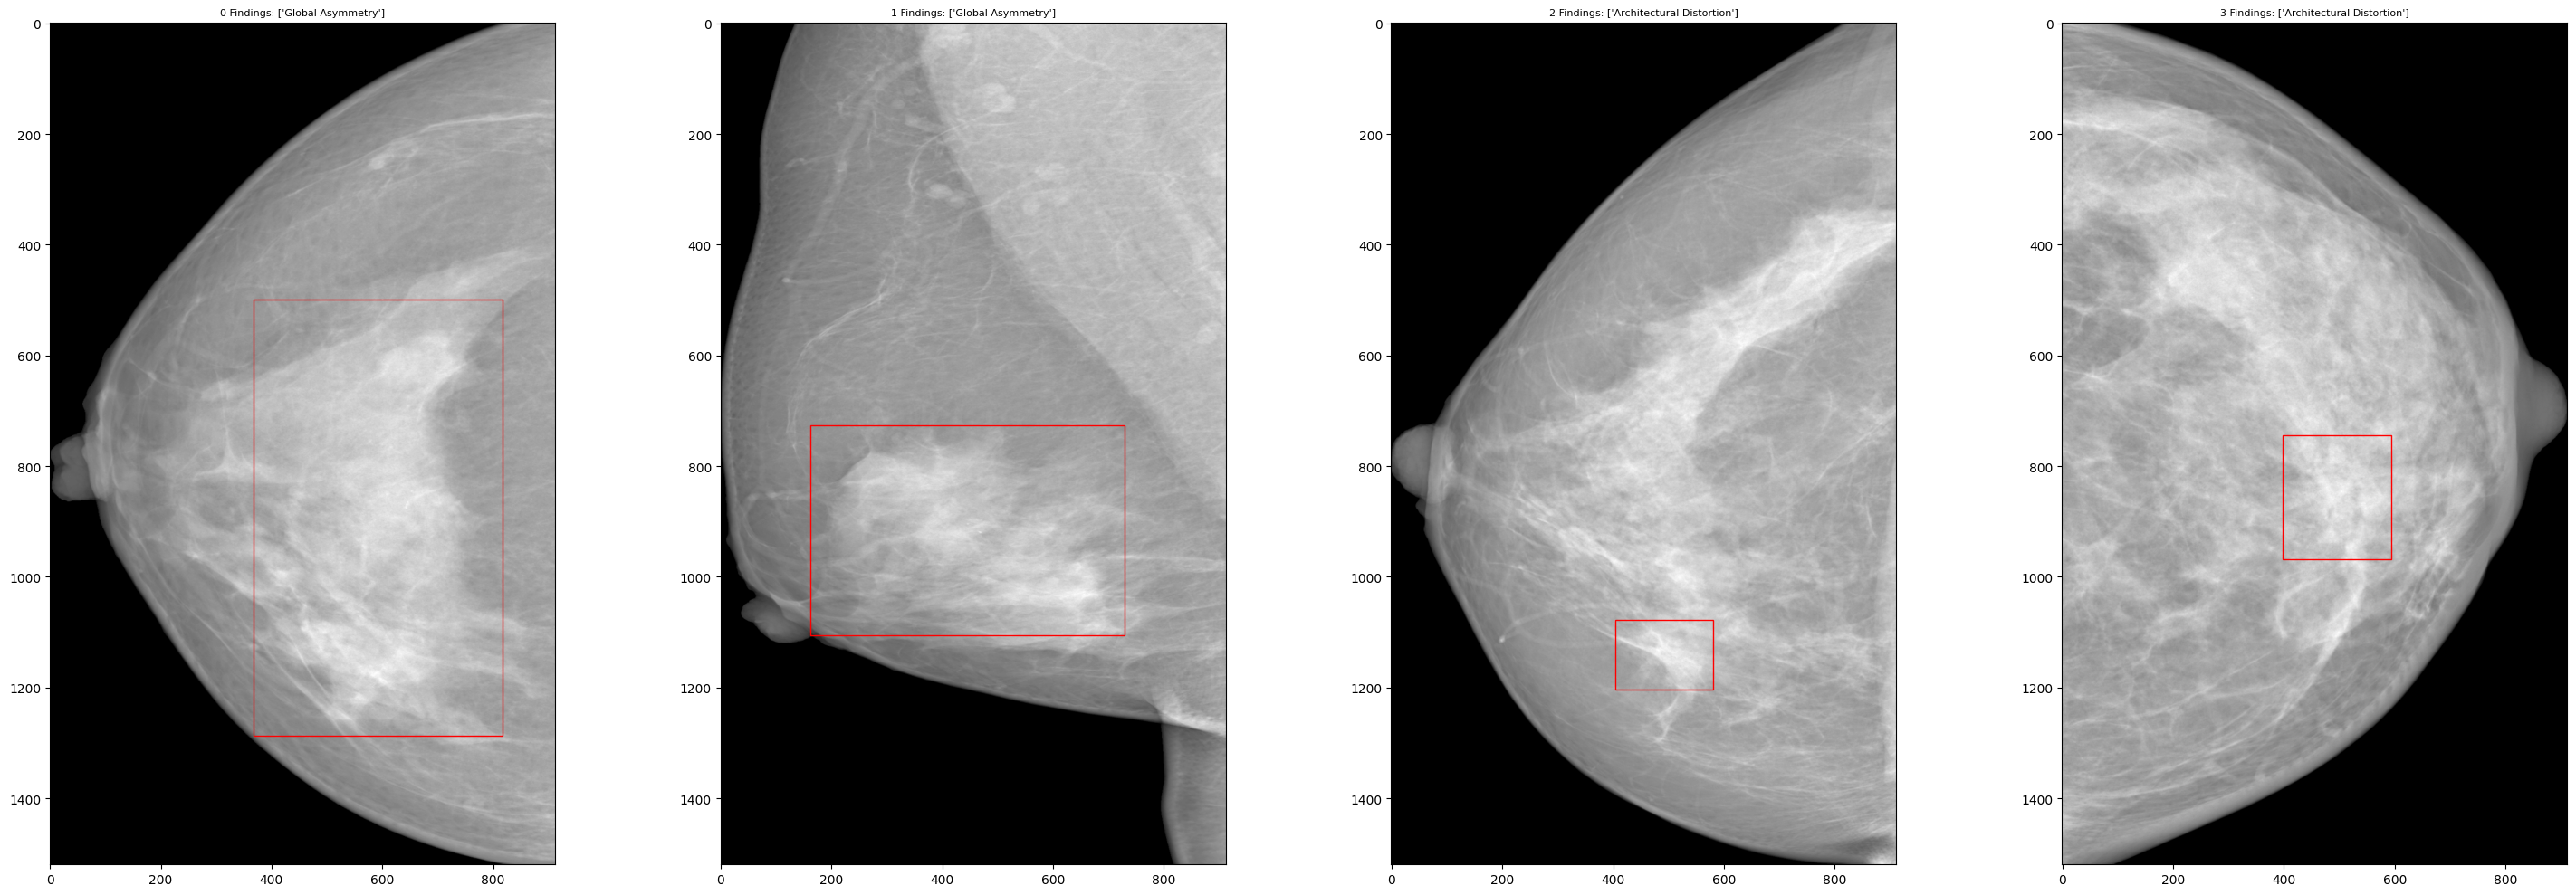

In [4]:
# idx =  random.sample(range(find_emory.shape[0]), 4)
idx = [2, 3, 4, 14]
display_images(vini, idx)

## Let's Extract Breast Regions

In [5]:
import torch
import cv2
import numpy as np
from PIL import Image

def resize_with_padding_vini(img_np, target_size=(512, 512), padding=1):
    # Convert image to a torch tensor if not already
    img_torch = torch.from_numpy(img_np).to(torch.float32)

    # Ensure the breast region fits within a consistent scale
    breast_height, breast_width = img_torch.shape
    aspect_ratio = breast_width / breast_height

    # Define target dimensions based on aspect ratio
    if aspect_ratio > 1:
        # Wider than tall
        new_width = target_size[1] - padding
        new_height = int(new_width / aspect_ratio)
    else:
        # Taller than wide
        new_height = target_size[0] - padding
        new_width = int(new_height * aspect_ratio)
    
    # Resize while maintaining the aspect ratio
    resized_breast = cv2.resize(img_np, (new_width, new_height))
    resized_breast = torch.from_numpy(resized_breast)

     # Determine which side has lower intensity
    pad_x = target_size[1] - new_width
    pad_y = target_size[0] - new_height

    # Initialize offsets
    x_offset = 0
    y_offset = 0
    left_intensity = 0
    right_intensity = 0
    top_intensity = 0
    bottom_intensity = 0

    # Decide padding side for x-axis
    if pad_x > 0:
        left_intensity = resized_breast[:, 0].mean()
        right_intensity = resized_breast[:, -1].mean()
        if left_intensity < right_intensity:
            # Pad on the left side
            x_offset = pad_x
        else:
            # Pad on the right side
            x_offset = 0

    # Decide padding side for y-axis
    if pad_y > 0:
        top_intensity = resized_breast[0, :].mean()
        bottom_intensity = resized_breast[-1, :].mean()
        if top_intensity < bottom_intensity:
            # Pad on the top side
            y_offset = pad_y
        else:
            # Pad on the bottom side
            y_offset = 0

    # Create a padded image with the target size and place the resized breast region
    padded_img = torch.zeros(target_size, dtype=resized_breast.dtype)
    padded_img[y_offset:y_offset + new_height, x_offset:x_offset + new_width] = resized_breast

    data = {'padded_img':padded_img,
        'breast_region': img_torch,
        'left_intensity': left_intensity,
        'right_intensity': right_intensity,
        'top_intensity': top_intensity,
        'bottom_intensity': bottom_intensity,
        'target_size': target_size,
        'padding': padding
       }

    return data


In [6]:
def apply_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized_img = clahe.apply(image)
    return equalized_img

def mean_variance_normalization(img_torch):
    img_min, img_max = img_torch.min(), img_torch.max()
    img_torch = (img_torch - img_min) / (img_max - img_min) * 255
    return img_torch

def transform_bbox(original_bbox, data):
    """
    Transform bounding box coordinates from original image space to resized and padded space.
    
    Args:
        original_bbox (tuple): (x1, y1, x2, y2) in original image space (3500x2680)
    Returns:
        tuple: Transformed (x1, y1, x2, y2) coordinates in the new image space
    """
    orig_x1, orig_y1, orig_x2, orig_y2 = original_bbox
    
    breast_region_shape = data['breast_region'].shape
    breast_height, breast_width = breast_region_shape
    target_size = data['target_size']
    padding = data['padding']
    left_intensity = data['left_intensity']
    right_intensity = data['right_intensity']
    top_intensity = data['top_intensity']
    bottom_intensity = data['bottom_intensity']
    
    # Calculate aspect ratio of the breast region
    aspect_ratio = breast_width / breast_height
    
    # Determine the dimensions after resize (before padding)
    if aspect_ratio > 1:
        # Wider than tall
        new_width = target_size[1] - padding
        new_height = int(new_width / aspect_ratio)
    else:
        # Taller than wide
        new_height = target_size[0] - padding
        new_width = int(new_height * aspect_ratio)
    
    # Calculate scaling factors
    scale_x = new_width / breast_width
    scale_y = new_height / breast_height
    
    # Scale the bbox coordinates
    scaled_x1 = int(orig_x1 * scale_x)
    scaled_y1 = int(orig_y1 * scale_y)
    scaled_x2 = int(orig_x2 * scale_x)
    scaled_y2 = int(orig_y2 * scale_y)
    
    # Calculate padding offsets based on image dimensions
    pad_x = target_size[1] - new_width
    pad_y = target_size[0] - new_height
    
    # Get the intensity values from the edges of the breast region
    # You'll need to pass these values or compute them here
    # For now, we'll assume they're computed the same way as in your original function
    x_offset = pad_x if left_intensity < right_intensity else 0
    y_offset = pad_y if top_intensity < bottom_intensity else 0
    
    # Apply offsets to the scaled coordinates
    final_x1 = scaled_x1 + x_offset
    final_y1 = scaled_y1 + y_offset
    final_x2 = scaled_x2 + x_offset
    final_y2 = scaled_y2 + y_offset
    
    # Ensure coordinates are within bounds
    final_x1 = max(0, min(final_x1, target_size[1]-1))
    final_y1 = max(0, min(final_y1, target_size[0]-1))
    final_x2 = max(0, min(final_x2, target_size[1]-1))
    final_y2 = max(0, min(final_y2, target_size[0]-1))
    
    return (final_x1, final_y1, final_x2, final_y2)

In [7]:
def display_image_transform(data, idx):
    # Set the plot size
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(30, 10))
    axes = axes.ravel()

    for i, row in enumerate(data.iloc[idx].itertuples()):
        # Build image path
        img_file_path = row.image_paths

        # Open and show image
        if os.path.exists(img_file_path):
            img_np = cv2.imread(img_file_path, cv2.IMREAD_GRAYSCALE)
            img_np = mean_variance_normalization(img_np)
            image_data = resize_with_padding_vini(img_np, padding=0)
            # Convert the result back to a NumPy array for visualization or further processing
            padded_img_np = image_data['padded_img'].cpu().numpy().astype(np.uint8)
            x1, y1, x2, y2 = row.resized_xmin, row.resized_ymin, row.resized_xmax, row.resized_ymax
            adj_roi=transform_bbox((x1, y1, x2, y2), image_data)
            x1, y1, x2, y2 = adj_roi
            
            try:
                axes[i].imshow(padded_img_np, cmap='gray')

                # Draw bounding box
                rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
                axes[i].add_patch(rect)
            except Exception as e:
                print(f"Cannot Display {img_file_path}, because of error:{e}")
                break
                    
        else:
            axes[i].text(0.5, 0.5, 'Image not found', horizontalalignment='center', verticalalignment='center')
        
        # Set title with image attributes
        title_text = f"{i} Findings: {row.finding_categories}"
        axes[i].set_title(title_text, fontsize=8)
        # axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

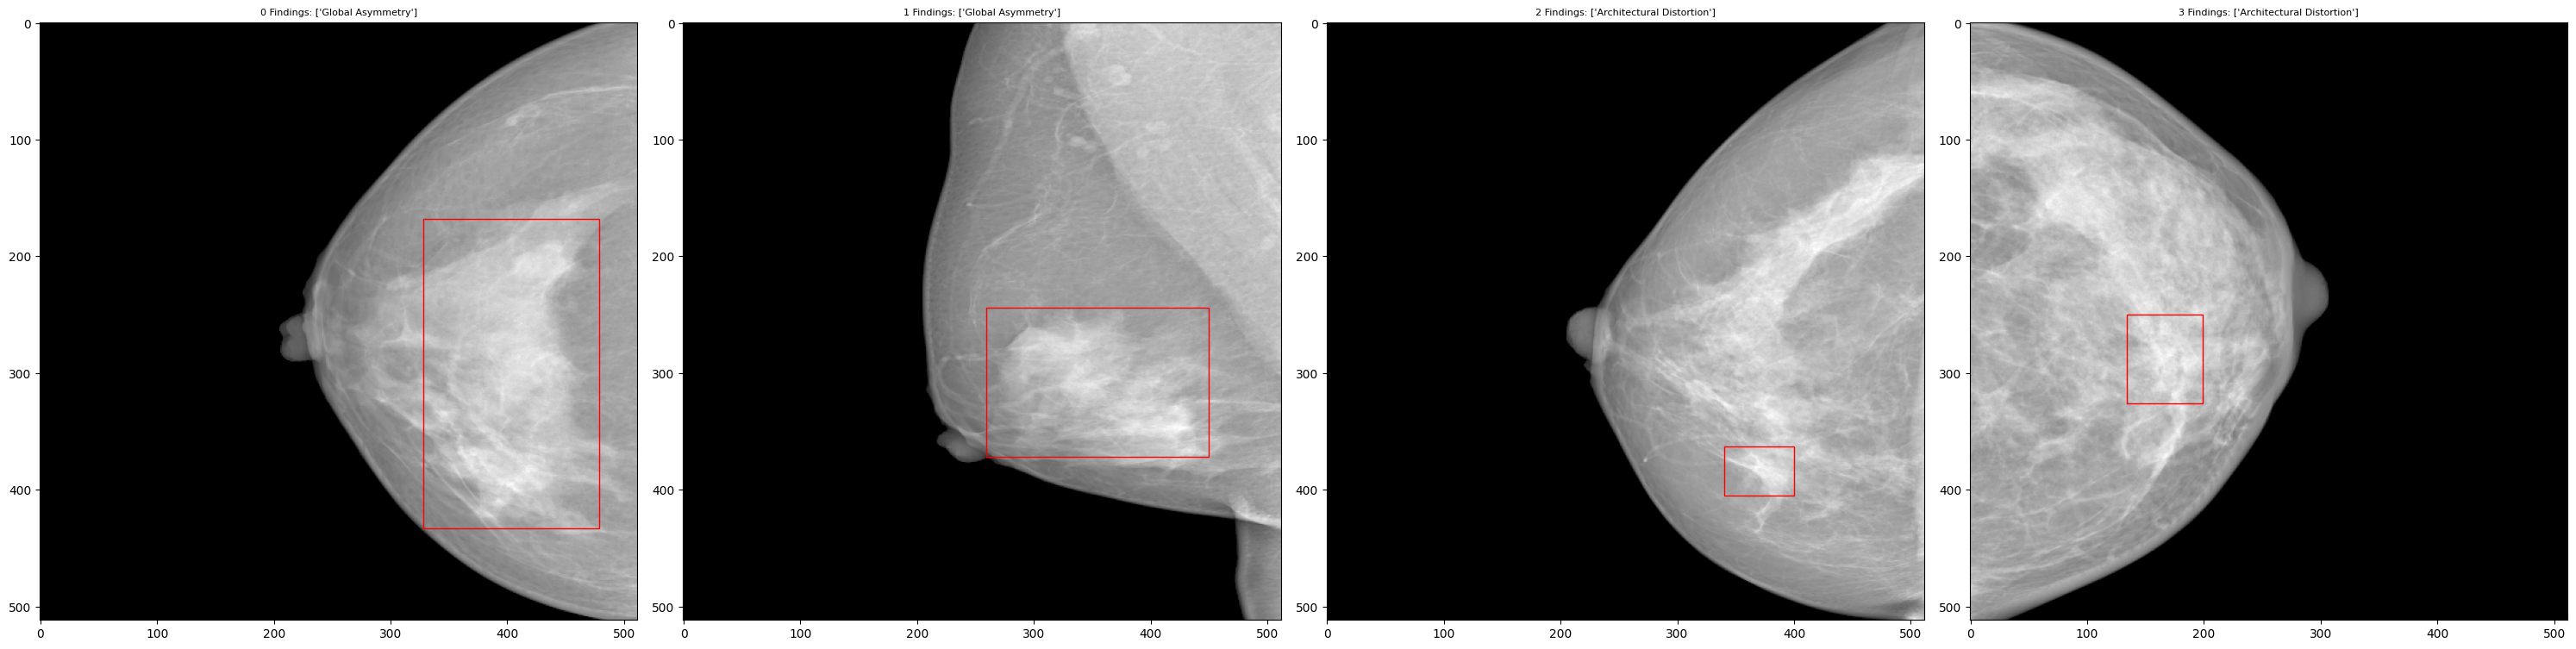

In [8]:
# idx =  random.sample(range(find_emory.shape[0]), 4)
display_image_transform(vini, idx)

## Let's Generate Synthetic Mammograms

In [9]:
from torch.utils.data import Dataset, DataLoader
import xformers
# from accelerate.utils import set_seed
from diffusers import (
    # AutoencoderKL,
    # DDPMScheduler,
    # DiffusionPipeline,
    # DPMSolverMultistepScheduler,
    # UNet2DConditionModel,
    # DDIMScheduler,
    StableDiffusionPipeline,
    StableDiffusionInpaintPipeline
)

import wandb

In [10]:
output_dir="results_2/mass/test"

In [ ]:
# Load the trained inpainting pipeline
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    output_dir,
    safety_checker=None,
    torch_dtype=torch.float16
).to("cuda")
generator = torch.Generator(device='cuda')
pipe.enable_xformers_memory_efficient_attention()

In [11]:
def prepare_mask_and_masked_image(image, mask):
    # Convert image to a NumPy array if it's a PIL Image
    if isinstance(image, Image.Image):
        image = np.array(image)

    # Ensure the image is RGB
    if len(image.shape) != 3 or image.shape[2] != 3:
        raise ValueError(f"Expected an RGB image, but got shape {image.shape}")

    # Convert mask to NumPy array and normalize to [0, 1]
    if isinstance(mask, Image.Image):
        mask = np.array(mask.convert("L"))  # Ensure mask is grayscale
    # mask = mask.astype(np.float32) / 255.0
    mask[mask < 0.5] = 0
    mask[mask >= 0.5] = 1

    # Expand the mask to 3 channels to match the image
    mask_3d = np.stack([mask] * 3, axis=-1)

    # Apply the mask to the image (invert mask for "masked" areas)
    masked_image = image * (1 - mask_3d)

    return mask, masked_image


def roi_mask(image_shape, roi_coords):
    # Create an empty mask
    mask = np.zeros(image_shape, dtype=np.uint8)
    x_min, y_min, x_max, y_max = roi_coords
    mask[y_min:y_max, x_min:x_max] = 1
    return mask

def return_image_mask(image_path, roi_coords):
    try:
        img_np = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        img_np = mean_variance_normalization(img_np)
        image_data = resize_with_padding_vini(img_np, padding=0)
        # Convert the result back to a NumPy array for visualization or further processing
        padded_img_np = image_data['padded_img'].cpu().numpy().astype(np.uint8)
        padded_img_rgb = np.repeat(padded_img_np[:, :, np.newaxis], 3, axis=2)
        padded_image = Image.fromarray(padded_img_rgb)

        x1, y1, x2, y2 = roi_coords
        adj_roi=transform_bbox((x1, y1, x2, y2), image_data)
        x1, y1, x2, y2 = adj_roi

        # Create a binary mask
        mask = roi_mask(padded_image.size[::-1], (x1, y1, x2, y2))
        roi = (x1, y1, x2, y2)
    except Exception as e:
        padded_image = None
        mask = None
        roi = None
    return padded_image, mask, roi


In [12]:
vini.iloc[28].image_paths

'vinidr-mammogram-dataset/images_png/edeb665b46be2c53fdfe54de4689e7eb/c550be907c02d0f89a264b0cda64e1c6.png'

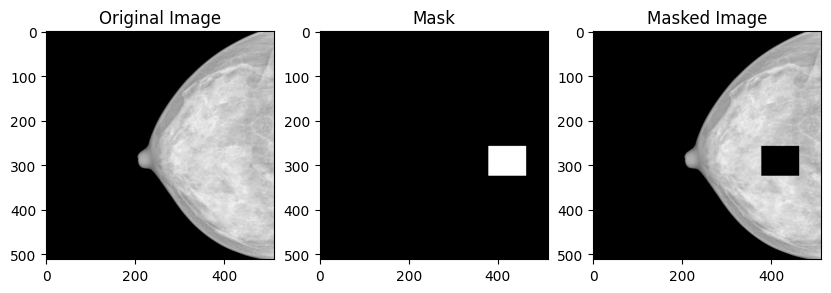

In [13]:
# Prepare the mask and masked image
row = vini.iloc[28]
padded_image, mask, _ = return_image_mask(row.image_paths, (row.resized_xmin, row.resized_ymin, row.resized_xmax, row.resized_ymax))
mask, masked_image = prepare_mask_and_masked_image(padded_image, mask)

# Display or save the results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(padded_image)
plt.subplot(1, 3, 2)
plt.title("Mask")
plt.imshow(mask, cmap="gray")
plt.subplot(1, 3, 3)
plt.title("Masked Image")
plt.imshow(masked_image.astype(np.uint8))
plt.show()

In [14]:
def show_row(imgs, figsize=(10, 10), title="", **kwargs):
    """Show generated images in a row

    Args:
        imgs (list): images list (PILs or numpy arrays)
        figsize (tuple, optional): figure size. Defaults to (10, 10).
        title (str, optional): title. Defaults to "".
    """
    fig, axs = plt.subplots(1, len(imgs), figsize=figsize)
    fig.suptitle(title)
    for i, img in enumerate(imgs):
        axs[i].imshow(img, **kwargs)
        axs[i].axis("off")
    fig.tight_layout()

In [ ]:
### generate images ###

#HP
guidance_scale = [2, 3, 4]
seed = 1337
generator.manual_seed(seed)
negative_prompt = ""
num_samples = 2
num_inference_steps = 24
size = 512

for i in guidance_scale:
    with torch.autocast("cuda"), torch.inference_mode():
        image = pipe(
            prompt="A mammogram with a mass lesion",
            image=padded_image,
            mask_image=mask,
            negative_prompt=negative_prompt,
            num_images_per_prompt=num_samples,
            num_inference_steps=num_inference_steps,
            guidance_scale=i,
            height=size,
            width=size,
            generator=generator,
        ).images
        
        imgs = [np.asarray(img) for img in image]

        show_row(imgs, title=f'Guidance: {i}, prompt: A mammogram with a mass lesion', figsize=(20,5), cmap="gray") if len(imgs) > 1 else plt.imshow(imgs[0], cmap="gray")

# show images

In [15]:
def generate(
    class_data_dir,
    data,
    classname,
    diffusion_path="results1.5/test",
    num_class_images=2000,
    batch_size=16,
    device="cuda"
):
    # Setup
    class_images_dir = Path(class_data_dir) / classname
    class_images_dir.mkdir(parents=True, exist_ok=True)
    cur_class_images = len(list(class_images_dir.iterdir()))

    pipe = StableDiffusionInpaintPipeline.from_pretrained(
        diffusion_path,
        safety_checker=None,
        torch_dtype=torch.float16
    ).to(device)
    pipe.enable_xformers_memory_efficient_attention()
    pipe.set_progress_bar_config(disable=True)

    prompt = f"A mammogram with a {classname} lesion"
    num_new_images = num_class_images - cur_class_images
    print(f"Number of class images to sample: {num_new_images}.")

    # Precompute image and mask pairs
    image_mask_pairs = [
        return_image_mask(row.image_paths, (row.resized_xmin, row.resized_ymin, row.resized_xmax, row.resized_ymax))
        for _, row in data.iterrows()
    ]
    images = [pair[0] for pair in image_mask_pairs if pair[0] is not None]
    masks = [pair[1] for pair in image_mask_pairs if pair[1] is not None]
    rois = [pair[2] for pair in image_mask_pairs if pair[2] is not None]
    
    generated_rois = []


    # Initialize tqdm progress bar
    with tqdm(total=num_new_images, desc="Generating Images", unit="image") as pbar:
        while num_new_images > 0:
            for i in range(0, len(images), batch_size):
                batch_size = min(batch_size, num_new_images)
                batch_images = images[i:i+batch_size]
                batch_masks = masks[i:i+batch_size]
                batch_prompts = [prompt] * len(batch_images)
                batch_rois = rois[i:i+batch_size]

                # Generate images
                scale = random.uniform(2.0, 3.0)
                step_count = random.randint(20, 25)
                results = pipe(
                    prompt=batch_prompts,
                    image=batch_images,
                    mask_image=batch_masks,
                    num_inference_steps=step_count,
                    guidance_scale=scale
                ).images

                # Save images
                for idx, image in enumerate(results):
                    hash_image = hashlib.sha1(image.tobytes()).hexdigest()
                    filename = class_images_dir / f"{cur_class_images + idx}-{hash_image}.png"
                    image.save(filename)
                    
                    # Append the corresponding ROI to the list
                    generated_rois.append(batch_rois[idx])

                # Update progress
                num_new_images -= len(batch_images)
                cur_class_images += len(batch_images)
                pbar.update(len(batch_images))

                if num_new_images <= 0:
                    break

    # Cleanup
    del pipe
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        
    return generated_rois



In [ ]:
os.makedirs('synthetic_vlesions', exist_ok=True)

class_data_dir = 'synthetic_vlesions'

In [ ]:
classname="mass"

mass = vini[vini['category'].str.lower()=='mass'].reset_index(drop=True)


diffusion_path = "results_2/mass/test"

mass_rois = generate(class_data_dir, 
         mass, 
         classname, 
         diffusion_path=diffusion_path, 
         num_class_images=2000,
         batch_size=32)

In [ ]:
with open(f"{class_data_dir}/mass/generated_rois.json", "w") as f:
    json.dump(mass_rois, f)

In [ ]:
# dt = find_emory[find_emory['category']=='Asymmetry'].reset_index(drop=True)
# dt = dt.drop([5],axis=0).reset_index(drop=True)

In [ ]:
classname="asymmetry"

dt = vini[vini['category'].str.lower()=='asymmetry'].reset_index(drop=True)
diffusion_path = "results_2/asymmetry/test"

asym_rois = generate(class_data_dir, 
         dt, 
         classname, 
         diffusion_path=diffusion_path, 
         num_class_images=2000, 
         batch_size=32)

In [ ]:
with open(f"{class_data_dir}/asymmetry/generated_rois.json", "w") as f:
    json.dump(asym_rois, f)

In [ ]:
classname="suspicious calcification"

dt = vini[vini['category'].str.lower()=='suspicious calcification'].reset_index(drop=True)
diffusion_path = "results_2/suspic_calc/test"

suspi_calc = generate(class_data_dir, 
         dt, 
         classname, 
         diffusion_path=diffusion_path, 
         num_class_images=2000,
         batch_size=32)

In [ ]:
with open(f"{class_data_dir}/suspicious calcification/generated_rois.json", "w") as f:
    json.dump(suspi_calc, f)
    

In [16]:
vini['category'].value_counts() + 2000

category
Mass                        3226
Suspicious Calcification    2453
Focal Asymmetry             2236
Architectural Distortion    2096
Asymmetry                   2092
Suspicious Lymph Node       2057
Skin Thickening             2049
Global Asymmetry            2024
Nipple Retraction           2014
Skin Retraction             2007
Name: count, dtype: int64

In [17]:
# Define the mapping dictionary
category_mapping = {
    'asymmetry': 0,
    'focal asymmetry':0,
    'global asymmetry':0,
    'architectural distortion':0,
    'nipple retraction':0,
    'skin retraction':0,
    'suspicious calcification':1,
    'mass':2,
    'suspicious lymph node':2,
    'skin thickening':2,
}

train_data = vini.copy()
train_data['category'] = train_data['category'].str.lower()
train_data['category'] = train_data['category'].map(category_mapping)

In [19]:
cat_map = {'asymmetry':0, 'suspicious calcification':1, 'mass':2}

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
train, val = train_test_split(train_data, test_size=0.2, stratify=train_data['category'])

In [22]:
train, val = train.reset_index(drop=True), val.reset_index(drop=True)

In [26]:
os.makedirs('vini_yolo/train/images', exist_ok=True)
os.makedirs('vini_yolo/train/labels', exist_ok=True)

os.makedirs('vini_yolo/val/images', exist_ok=True)
os.makedirs('vini_yolo/val/labels', exist_ok=True)

In [27]:
def get_bboxes_yolo(data, dst_path, label_path):
    for i, row in tqdm(enumerate(data.itertuples()), desc="Getting BBoxes.."):
        
        img_file_path = row.image_paths
        if os.path.exists(img_file_path):
            
            try:
                img_np = cv2.imread(img_file_path, cv2.IMREAD_GRAYSCALE)
                img_np = mean_variance_normalization(img_np)
                image_data = resize_with_padding_vini(img_np, padding=0)
                # Convert the result back to a NumPy array for visualization or further processing
                padded_img_np = image_data['padded_img'].cpu().numpy().astype(np.uint8)
    
                padded_img_rgb = np.repeat(padded_img_np[:, :, np.newaxis], 3, axis=2)
                padded_image = Image.fromarray(padded_img_rgb)

                dst_img_path = os.path.join(dst_path, f"{row.image_paths.split('/')[-1]}")
                padded_image.save(dst_img_path)

                label_file_path = os.path.join(label_path, f"{row.image_paths.split('/')[-1].replace('.png','.txt')}")
                width, height = padded_image.size
                
                x1, y1, x2, y2 = row.resized_xmin, row.resized_ymin, row.resized_xmax, row.resized_ymax
                adj_roi=transform_bbox((x1, y1, x2, y2), image_data)
                x1, y1, x2, y2 = adj_roi

                x_center = ((x1 + x2) / 2) / width
                y_center = ((y1 + y2) / 2) / height
                wid = (x2 - x1) / width
                hei = (y2 - y1) / height

                # print(f"YOLO FORMAT: category:{row.category}, x_center:{x_center}, y_center:{y_center}, wid:{wid}, hei:{hei}\n")

                text = [row.category, x_center, y_center, wid, hei]
                with open(label_file_path, 'w') as f:
                    text = [str(i) for i in text]
                    f.write(' '.join(text))
            except Exception as e:
                print(f"Cannot open File {img_file_path} because of exception{e}")
                break
        else:
            print(f"FILE NOT FOUND {img_file_path}")
                 
get_bboxes_yolo(train, dst_path="vini_yolo/train/images", label_path="vini_yolo/train/labels")
get_bboxes_yolo(val,  dst_path="vini_yolo/val/images", label_path="vini_yolo/val/labels")

Getting BBoxes..: 0it [00:00, ?it/s]

Getting BBoxes..: 0it [00:00, ?it/s]

In [29]:
def get_bboxes_synth_yolo(class_data_dir, dst_path, label_path):
    # Retrieve all synthetic images and corresponding ROIs across the 3 lesions
    lesion_dirs = {
        "asymmetry": os.path.join(class_data_dir, "asymmetry"),
        "suspicious calcification": os.path.join(class_data_dir, "suspicious calcification"),
        "mass": os.path.join(class_data_dir, "mass"),
    }
    
    # Load images and ROIs
    image_roi_pairs = []
    for lesion_name, lesion_dir in lesion_dirs.items():
        roi_path = os.path.join(lesion_dir, "generated_rois.json")
        with open(roi_path, "r") as f:
            rois = json.load(f)

        lesion_images = sorted([os.path.join(lesion_dir, img) for img in os.listdir(lesion_dir) if img.endswith(".png")])
        if len(lesion_images) != len(rois):
            print(f"Warning: Number of images and ROIs do not match in {lesion_name}.")
            continue

        image_roi_pairs.extend([(img, roi, lesion_name) for img, roi in zip(lesion_images, rois)])

    # Shuffle the images and corresponding ROIs
    random.shuffle(image_roi_pairs)

    # Process and copy images to the destination path
    for i, (img_path, roi, lesion_name) in tqdm(enumerate(image_roi_pairs), desc="Processing Images", unit="image"):
        try:
            # Build destination file paths
            image_id = f"{lesion_name.lower()}_{i:06d}"
            dst_img_path = os.path.join(dst_path, f"{image_id}.png")
            label_file_path = os.path.join(label_path, f"{image_id}.txt")

            # Open and process the image
            if os.path.exists(img_path):
                img = Image.open(img_path)
                shutil.copy(img_path, dst_img_path)
                width, height = img.size
                x1, y1, x2, y2 = roi

                # Convert bounding box to YOLO format
                x_center = ((x1 + x2) / 2) / width
                y_center = ((y1 + y2) / 2) / height
                bbox_width = (x2 - x1) / width
                bbox_height = (y2 - y1) / height

                # Write label file in YOLO format
                category = list(cat_map.keys()).index(lesion_name)  # Get category index
                label_text = f"{category} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}\n"
                with open(label_file_path, 'w') as f:
                    f.write(label_text)
            else:
                print(f"Image file not found: {img_path}")

        except Exception as e:
            print(f"Error processing {img_path}: {e}")

    print(f"Finished processing. Images and labels saved to {dst_path} and {label_path}.")
    
get_bboxes_synth_yolo(class_data_dir="synthetic_lesions",dst_path="vini_yolo/train/images",label_path="vini_yolo/train/labels")


Processing Images: 0image [00:00, ?image/s]

Finished processing. Images and labels saved to vini_yolo/train/images and vini_yolo/train/labels.


In [32]:
data = dict(
    train = "/notebooks/vini_yolo/train/images",
    val = "/notebooks/vini_yolo/val/images",

    nc = len(cat_map),
    names = list(cat_map.keys())
)

with open('vini_yolo/data.yaml', 'w') as outfile:
    yaml.dump(data, outfile)

In [33]:
from ultralytics import YOLO
model = YOLO('yolov8m.pt')

In [ ]:
yaml_file = 'vini_yolo/data.yaml'

model.train(data=yaml_file,
            epochs=50,
            patience=20,
            batch=64,
            optimizer='Adam',
            lr0 = 1e-4,
            lrf = 1e-3,
            weight_decay = 5e-4,
            name = f'yolov8s_3classes_vinisynth',
            save=True,
            amp=True,
            val=True)

In [ ]:
# Define the path to the directory
post_training_files_path = 'runs/detect/yolov8s_3classes_vinisynth'

# Construct the path to the best model weights file using os.path.join
best_model_path = os.path.join(post_training_files_path, 'weights/best.pt')

# Load the best model weights into the YOLO model
best_model = YOLO(best_model_path)

# Validate the best model using the validation set with default parameters
metrics = best_model.val(split='val')

In [36]:
# Convert the dictionary to a pandas DataFrame and use the keys as the index
metrics = pd.DataFrame.from_dict(metrics.results_dict, orient='index', columns=['Metric Value'])

In [ ]:
# Configure the visual appearance of Seaborn plots
sns.set(rc={'axes.facecolor': '#9b63b8'}, style='darkgrid')

def display_images(post_training_files_path, image_files):
    
    for image_file in image_files:
        image_path = os.path.join(post_training_files_path, image_file)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.figure(figsize=(10, 10), dpi=120)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

# List of image files to display
image_files = [
    'confusion_matrix_normalized.png',
    'F1_curve.png',
    'P_curve.png',
    'R_curve.png',
    'PR_curve.png',
    'results.png'
]

# Display the images
display_images(post_training_files_path, image_files)